In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
# load the data
url = 'titanic-train.csv'
df = pd.read_csv(url)
df.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']


In [3]:
# inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


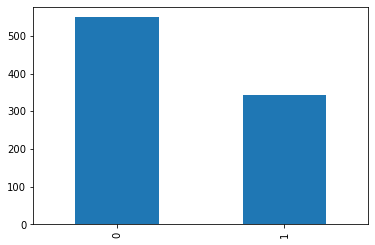

In [10]:
# Check de class variabele 
df['Survived'].value_counts().plot(kind='bar')

In [11]:
## Check missing values
# We kunnen makkelijk checken op missing values met de isnull methode
df.isnull().sum()
#de set bevat missing values op Age en Cabin

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

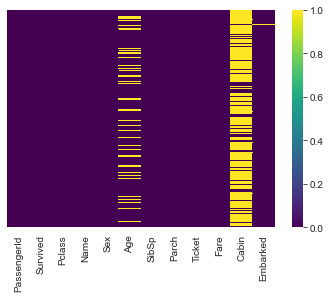

In [12]:
# Kan ook grafisch
sns.set_style("whitegrid")

sns.heatmap(df.isnull(), yticklabels=False, cmap="viridis")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


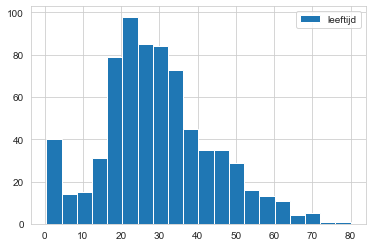

In [14]:
# plot the data
df.Age.hist(bins=20, label='leeftijd')
plt.legend()

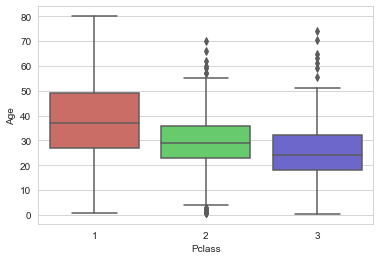

In [16]:
# data is wijd verspreid, dus hoe data missing values in te vullen?
# Is er een relatie met klasse?
sns.boxplot(x='Pclass', y='Age', data=df, palette='hls')

Grof gezegd kunnen we zeggen dat hoe jonger een passagier is, hoe groter de kans is dat hij in de 3e klas zit. Hoe ouder een passagier is, hoe groter de kans dat hij in de 1e klas zit. Er is dus een losse relatie tussen deze variabelen. Laten we dus een functie schrijven die de leeftijd van de passagier benadert, op basis van hun klasse. Uit de boxplot blijkt dat de gemiddelde leeftijd van de 1e klas passagiers ongeveer 37 is, de 2e klas passagiers 29 is en de 3e klas passagiers 24 is.

Laten we dus een functie schrijven die elke nulwaarde in de variabele `Age` vindt en voor elke nul de waarde van de `Pclass` controleert en een leeftijdwaarde toekent op basis van de gemiddelde leeftijd van passagiers in die klasse.

In [17]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        return 24
    return Age

In [18]:
df['Age'] = df[['Age', 'Pclass']].apply(age_approx, axis=1)
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
# waarschijnlijk doen naam, ticket en cabin er niet toe, deze kunnen we verwijderen
df = df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [21]:
#verwijderen van de rijen met de twee waardes nul in de Embarked zal niet veel uitmaken
df.dropna(inplace=True)
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [23]:
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


In [24]:
#Sex en Embarked moeten numeriek gemaakt worden
df['Sex'] = df['Sex'].map({'female': '1', 'male': '0'})

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S


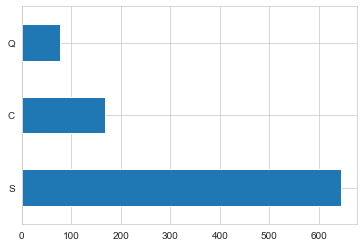

In [25]:
df.Embarked.value_counts().plot(kind='barh')

In [26]:
df['Embarked'] = df['Embarked'].map({'C': '1', 'S': '2', 'Q': '3'})
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,2
3,1,1,1,35.0,1,0,53.1000,2
4,0,3,0,35.0,0,0,8.0500,2


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [28]:
df['Sex'] = pd.to_numeric(df['Sex'])
df['Embarked'] = pd.to_numeric(df['Embarked'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    int64  
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 62.5 KB


In [29]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,2
3,1,1,1,35.0,1,0,53.1000,2
4,0,3,0,35.0,0,0,8.0500,2


In [30]:
#get X en y
y = np.array(df['Survived'])
X = np.array(df.iloc[:,2:9])
X.shape

(889, 6)

In [32]:
#normaliseer
def normalize(X):
    scaler = StandardScaler()
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    return X

X = normalize(X)

In [33]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

# train
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

In [34]:
#evalueer
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))

[[145  22]
 [ 30  70]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       167
           1       0.76      0.70      0.73       100

    accuracy                           0.81       267
   macro avg       0.79      0.78      0.79       267
weighted avg       0.80      0.81      0.80       267

